In [12]:
#pip install ipyplot

In [13]:
from skimage.transform import pyramid_gaussian
from skimage import data
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, binary_opening, remove_small_holes, binary_erosion, binary_dilation
from skimage import measure
from skimage import data
from skimage.morphology import skeletonize, disk, ball
from skimage.filters import threshold_local, threshold_sauvola, threshold_niblack, threshold_otsu, rank

from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import gaussian_filter

from scipy import ndimage
from scipy import stats

import os
import numpy as np
import sys
import statistics
from scipy import ndimage
import math
import SimpleITK as sitk
import gc
from PIL import Image
import cv2 

from matplotlib import pyplot as plt 
%matplotlib inline

In [14]:

def GetTissue(volume, threshold = 6, alpha = 1, alpha_1d = 1, keep_largest = False, min_size_tissue = 100, min_size_holes = 100):
    
    #print(file_name)
    #print(output_file_name)
    #print(threshold)
    #print(alpha)
    #print(alpha_1d)
    #print(keep_largest)
    #print(min_size_tissue)
    #print(min_size_holes)
    
    
    
    #volume_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")

    #volume_itk = sitk.GetImageFromArray(volume)
    
    #thresholder = sitk.BinaryThresholdImageFilter();
    #thresholder.SetLowerThreshold(threshold);
    #thresholder.SetOutsideValue(1);
    #thresholder.SetInsideValue(0);

    #result = thresholder.Execute(volume_itk);

    #sitk.WriteImage(result, "result.vtk");
    #sitk.WriteImage(volume_itk, "volume_itk.vtk");
    
    
    print(threshold)

    tissue = volume > threshold
    
    
    #tissue = tissue.astype(np.float)

#     if alpha > 0:
#         for i in range(0, tissue.shape[0]):
#             #print("{}/{}".format(i, tissue.shape[0]))
#             tissue[i,:,:] = ndimage.gaussian_filter(tissue[i,:,:], alpha)

#     if alpha_1d > 0:
#         tissue = ndimage.gaussian_filter1d(tissue, alpha_1d, 0)

    #tissue = tissue > 0.5

#     if min_size_tissue > 1:
#         tissue = remove_small_objects(tissue, min_size_tissue)
#     if min_size_holes > 1:
#         tissue = remove_small_holes(tissue, min_size_holes)

#     if keep_largest:
#         labels = label(tissue)
#         assert( labels.max() != 0 ) # assume at least 1 CC
#         tissue = labels == np.argmax(np.bincount(labels.flat)[1:])+1

    tissue = tissue.astype(np.uint8)

    # tissue_itk = sitk.GetImageFromArray(tissue)
    # sitk.WriteImage(tissue_itk, "tissue.vtk")
    # volume_itk = sitk.GetImageFromArray(volume)
    # sitk.WriteImage(volume_itk, "volume.vtk")
    
    
    #print("done")
    return tissue



In [15]:
def rotate(volume_itk, rotate):
    transform = sitk.Euler3DTransform()
    #rotate = -45
    rotation = rotate * 3.14159265359/180
    transform.SetIdentity()
    transform.SetCenter([int(volume_itk.GetSpacing()[0]*volume_itk.GetSize()[0]/2), int(volume_itk.GetSpacing()[1]*volume_itk.GetSize()[1]/2), int(volume_itk.GetSpacing()[2]*volume_itk.GetSize()[2]/2)])
    transform.SetRotation (0, 0, rotation)

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetSize([int(volume_itk.GetSize()[0]*1.5),int(volume_itk.GetSize()[1]*1.5),volume_itk.GetSize()[2]])
    resampler.SetOutputSpacing([volume_itk.GetSpacing()[0], volume_itk.GetSpacing()[1], volume_itk.GetSpacing()[2]])
    resampler.SetOutputOrigin([int(0.25*volume_itk.GetSpacing()[0]*-volume_itk.GetSize()[0]), int(0.25*volume_itk.GetSpacing()[1]*-volume_itk.GetSize()[1]), 0])
    resampler.SetOutputPixelType(sitk.sitkFloat32)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(transform)

    volume_itk = resampler.Execute(volume_itk)
    
    return volume_itk
    

In [16]:
def keep_largest(tissue):
    labels = label(tissue)
    assert( labels.max() != 0 ) # assume at least 1 CC
    tissue = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return tissue

In [17]:
def crop(volume, tissue):
    
    #Get crop region
    maxX_final = 0
    minX_final = sys.maxsize
    maxY_final = 0
    minY_final = sys.maxsize
    maxZ_final = 0
    minZ_final = sys.maxsize

    objs = ndimage.find_objects(tissue)
    maxY = int(objs[0][1].stop)
    minY = int(objs[0][1].start)
    maxZ = int(objs[0][2].stop)
    minZ = int(objs[0][2].start)

    maxY_final = max(maxY_final, maxY)
    minY_final = min(minY_final, minY)
    maxZ_final = max(maxZ_final, maxZ)
    minZ_final = min(minZ_final, minZ)

    minX_final = 0
    maxX_final = volume.shape[0]

    volume = volume[:,minY_final:maxY_final, minZ_final:maxZ_final]
    
    return volume

In [18]:
def get_regions(stroma, tissue, mode):
    
    
    dilation = 100
    #if mode == 0:
    #    dilation = 50
    
    if mode == 0: # center
        tissue2 = np.zeros([tissue.shape[0], tissue.shape[1]+dilation*2, tissue.shape[2]+dilation*2])
        tissue2[:, dilation:tissue.shape[1]+dilation, dilation:tissue.shape[2]+dilation] = tissue
    elif mode == 1: # quarter
        tissue2 = np.zeros([tissue.shape[0], tissue.shape[1]+dilation, tissue.shape[2]+dilation])
        tissue2[:, dilation:tissue.shape[1]+dilation, :tissue.shape[2]] = tissue
    elif mode == 2: # half
        tissue2 = np.zeros([tissue.shape[0], tissue.shape[1]+dilation*2, tissue.shape[2]+dilation])
        tissue2[:, dilation:tissue.shape[1]+dilation, :tissue.shape[2]] = tissue
    
    distance_map = distance_transform_edt(1-tissue2)
    #distance_map = gaussian_filter(distance_map, sigma=10)
    #plt.imshow(distance_map[int(distance_map.shape[0]/2)], interpolation='nearest')
    #plt.show()
    
    
        
    distance_map_itk = sitk.GetImageFromArray(distance_map.astype(int))
    sitk.WriteImage(distance_map_itk, "tmp1.nii")
    
    distance_map = distance_map < dilation
    #plt.imshow(distance_map[int(distance_map.shape[0]/2)], interpolation='nearest')
    #plt.show()
    distance_map_itk = sitk.GetImageFromArray(distance_map.astype(int))
    sitk.WriteImage(distance_map_itk, "tmp2.nii")

    distance_map = distance_transform_edt(distance_map)
    
    if mode == 0:
        distance_map = distance_map[:, dilation:distance_map.shape[1]-dilation, dilation:distance_map.shape[2]-dilation]
    if mode == 1:
        distance_map = distance_map[:, dilation:distance_map.shape[1], :distance_map.shape[2]-dilation]
    if mode == 2:
        distance_map = distance_map[:, dilation:distance_map.shape[1]-dilation, :distance_map.shape[2]-dilation]

    distance_map2 = np.zeros(distance_map.shape)
    nr_of_regions = 10

    for i in range(0, nr_of_regions):
        f_min = dilation + 133 * i;
        f_max = dilation + 133 * (i+1);

        distance_map2[(distance_map < f_max) & (distance_map >= f_min)] = i+1

    distance_map2[tissue != 1] = 0
    distance_map2[stroma == 1] += nr_of_regions+1
    distance_map2[tissue != 1] = 0
    
    return distance_map2


In [19]:

from matplotlib import pyplot as plt 
%matplotlib inline
from os.path import exists

def get_segmentation(file_name, rotation, threshold_tissue, threshold_stroma, mode):
    
    
    input_file_name = "../../Storage/processed/" + file_name + ".nii"
    output_file_name = "../../Storage/segmentations/" + file_name + ".nii"
    
    #if exists(output_file_name):
    #    return

    print(file_name)
    
    #volume_itk = sitk.ReadImage(file_name, imageIO="MetaImageIO")
    volume_itk = sitk.ReadImage(input_file_name)
    volume_itk.SetSpacing((7.5,7.5,7.5))
    volume = sitk.GetArrayFromImage(volume_itk)
    

    threshold = threshold_stroma
    alpha = 0
    alpha_1d = 0
    keep_the_largest = False
    min_size_tissue = 100
    min_size_holes = 100

    stroma = GetTissue(volume, threshold, alpha, alpha_1d, keep_the_largest, min_size_tissue, min_size_holes)

    threshold = threshold_tissue
    alpha = 0
    alpha_1d = 0
    keep_the_largest = False
    min_size_tissue = 1
    min_size_holes = 1

    tissue = GetTissue(volume, threshold, alpha, alpha_1d, keep_the_largest, min_size_tissue, min_size_holes)
    
    #tissue_itk = sitk.GetImageFromArray(tissue)
    #sitk.WriteImage(tissue_itk, "tissue_itk.nii")

    regions = get_regions(stroma, tissue, mode).astype(np.int8)
    regions_itk = sitk.GetImageFromArray(regions)
    regions_itk.SetSpacing((7.5,7.5,7.5))
    sitk.WriteImage(regions_itk, output_file_name)
    
    if True:
        plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
        plt.subplot(1, 3, 1)
        plt.imshow(  np.clip(volume[int(volume.shape[0]/2)], 0, 6) , interpolation='nearest')
        plt.subplot(1, 3, 2)
        plt.imshow(stroma[int(stroma.shape[0]/2)], interpolation='nearest')
        plt.subplot(1, 3, 3)
        plt.imshow(tissue[int(tissue.shape[0]/2)], interpolation='nearest')
        plt.show()

        plt.rcParams["figure.figsize"] = (20, 20) # (w, h)
        plt.imshow(np.clip(volume[:,:,int(volume.shape[2]/2)], 0, 6), interpolation='nearest')
        plt.show()
        plt.imshow(stroma[:,:,int(stroma.shape[2]/2)], interpolation='nearest')
        plt.show()
        plt.imshow(tissue[:,:,int(tissue.shape[2]/2)], interpolation='nearest')
        plt.show()
    
        plt.rcParams["figure.figsize"] = (10, 10) # (w, h)
        #clear_output(wait=True)
        plt.imshow(regions[int(regions.shape[0]/2)], interpolation='nearest', cmap=plt.get_cmap("nipy_spectral"), vmin=0, vmax=19)
        #plt.colorbar();
        #plt.savefig('regions.jpg')
        plt.show()
    



In [20]:




file_names_all = [
('20190911_PDX_STG316_gfp_100x15um', 1, 50, 0, 150, 0, -45, 0.3, 6, 0, 40),
('20190916_PDX_STG316_gfp_100x15um_set2', 1, 100, 0, 200, 0, -45, 0.3, 6, 0, 0),
('20190919_PDX_STG139645_gfp_100x15um', 2, 200, 0, 0, 0, 150, 0.3, 2.5, 0, 40),
('20190923_PDX_STG139645_gfp_100x15um_set2', 2, 200, 0, 0, 0, -210, 0.3, 3, 0, 0),
('20191021_PDX_STG143_100x15um', 2, 300, 0, 0, 0, -155, 0.2, 1, 0, 40),
('20191028_PDX_STG143_100x15um_set2', 2, 300, 0, 0, 0, -150, 0.3, 1.2, 0, 0),
('20191209_PDX_STG143SC_50x15um', 1, 50, 0, 750, 0, 75, 0.2, 2.25, 0, 0),
('20191210_PDX_STG143SC_100x15um_set2', 1, 150, 0, 750, 0, 70, 0.2, 1, 0, 30),  
('20200219_PDX_AB559_50X15um', 0, 0, 0, 0, 0, 0, 0.3, 5.0, 0, 0),
('20200225_PDX_Ab559_set2_100X15um', 0, 0, 0, 0, 0, 0, 0.2, 5, 0, 20),
('20200226_PDX_Ab580_HC_gfp_100x15um', 1, 200, 0, 200, 0, -20, 0.3, 2, 0, 0),
('20200227_PDX_Ab580_HC_gfp_set2_100x15um', 1, 200, 0, 100, 0, -18, 0.2, 4, 0, 40),
('20200615_PDX_AB580_GFP_100x15um_set1', 1, 100, 0, 100, 0, 45,  0.1, 2, 30, 1),
('20200629_PDX_PAR1040_GFP_100x15um_set1', 2, 150, 0, 0, 0, -100,  0.1, 4, 0, 0),
('20200707_PDX_PAR1040_GFP_100x15um_set2', 2, 150, 0, 0, 0, -105,  0.2, 2.5, 0, 0),
('20200804_PDX_AB580SC_gfp_100x15um_set1', 1, 200, 0, 100, 0, -170, 0.1, 2.5, 0, 0),
('20200817_PDX_AB764_017376_gfp_100x15um_set1', 1, 400, 0, 200, 0, 60,  0.07, 4, 0, 0),
('20200818_PDX_PAR1006_gfp_100x15um_set1', 1, 100, 0, 100, 0, 123, 0.1, 1.7, 1, 10),
('20200902_PDX_PAR1059_gfp_100x15um_set1', 2, 100, 0, 0, 0, 30, 0.1, 2, 0, 30), 
('20200908_PDX_PAR1022_gfp_100x15um_set1', 2, 200, 0, 0, 0, -120, 0.1, 3, 0, 50),
('20201103_PDX_PAR1022_GFP_Rep2_100x15um', 1, 100, 0, 100, 0, -130, 0.1, 2.5, 0, 0),
('20201109_PDX_STG1394_GFP_100x15um', 1, 300, 0, 100, 0, -90, 0.25, 2, 1, 40),
('20201110_PDX_HC1010_GFP_100x15um', 2, 200, 0, 0, 0, -100, 0.1, 1.5, 0, 0),
('20201207_PDX_PAR1059x2GFP_100x15um', 1, 300, 0, 0, 0, 45, 0.1, 1.7, 50, 0),
('20201216_PDX_STG143_SC_GFP_100x15um', 1, 200, 0, 100, 0, -120, 0.2, 1.5, 0, 0),
('20210104_PDX_AB580Sc_GFP_100x15um', 1, 250, 0, 100, 0, -100, 0.1, 0.5, 0, 0),
('20210105_PDX_STG316_GFP_rep1_100x15um', 1, 200, 0, 200, 0, -105, 0.05, 0.4, 0, 30),
('20210111_PDX_STG143_2HC_GFP_100x15um', 2, 100, 0, 0, 0, -45, 0.05, 0.12, 27, 0),
('20210119_PDX_STG316_GFP_100x15um', 1, 200, 0, 600, 0, 40, 0.1, 1, 0, 0),
('20210121_PDX_STG316_GFP_001389_100x15um', 1, 500, 250, 300, 100, 90, 0.05, 0.65, 0, 0),
('20210126_AB764_017377_100x15um_gfp', 2, 150, 0, 0, 0, 115, 0.2, 2.5, 50, 0),
('20210127_PDX_AB630_GFP_100x15um', 2, 150, 0, 0, 0, -35, 0.1, 1.3, 0, 0),   
('20210211_PDX_PAR1006_GFP_100x15um', 1, 400, 250, 200, 0, -60, 0.05, 1.2, 70, 0),
('20210315_PDX_AB582P_GFP_100x15um', 1, 150, 0, 100, 0, -220, 0.3, 9, 0, 0),
('20210406_PDX_CAHBHT_GFP_100x15um', 2, 200, 0, 0, 0, -135, 0.3, 4, 0, 0),
('20210407_PDX_STG139_GFP_100x15um', 1, 200, 0, 200, 0, 130, 0.3, 4, 0, 0),
('20210409_PDX_CAHBHTI_GFP_100x15um_set2', 2, 100, 0, 0, 0, 135, 0.3, 7, 0, 0),
('20210706_PDX_STG139_GFP_029630_100x15um', 2, 100, 0, 0, 0, -145, 0.3, 6, 0, 0),
('20211103_PDX_STG139M_GFP_031776_100x15um', 1, 150, 0, 100, 0, -135, 0.3, 8, 0, 0),
('20211104_PDX_STG139_GFP_039629_100x15um', 2, 250, 0, 0, 0, -140, 0.3, 8, 40, 0),
('20211108_PDX_STG139M_GFP_029620_100x15um', 2, 400, 0, 0, 0, -120, 0.3, 8, 0, 40),
('20211109_PDX_STG139_GFP_029630_100x15um', 2, 150, 0, 0, 0, 65, 0.3, 7, 0, 45),
('20211115_PDX_STG139_031772_50x15um', 1, 100, 0, 100, 0, -35, 0.3, 6, 0, 0),
('20211129_PDX_STG139_GFP_039629_100x15um', 2, 100, 0, 0, 0, -60, 0.3, 5, 0, 0),
('20220106_PDX_PAR1040_GFP_019611_100x15um', 1, 100, 0, 100, 300, -130, 0.1, 2.5, 15, 0), 
('20220110_PDX_STG139_GFP_018314_100x15um', 1, 700, 0, 200, 150, 125, 0.1, 2.5, 20, 0),
('20220127_PDX_PAR1040_GFP_019612_100x15um', 1, 300, 0, 100, 0, 39, 0.1, 3.0, 0, 0),
('20220214_PDX_STG139_GFP_019465_100x15um', 1, 300, 0, 200, 0, -65, 0.1, 0.6, 0, 0),
('20220223_PDX_STG139_GFP_018308_100x15um', 1, 150, 0, 150, 0, 60, 0.1, 0.8, 0, 0),
('20220228_PDX_PAR1040_GFP_019610_100x15um', 1, 250, 0, 450, 0, -50, 0.3, 13, 0, 0),
('20220428_PDX_AB559_GFP_002213_100x15um', 1, 100, 0, 300, 0, -45, 0.1, 12.0, 0, 0),
('20220503_PDX_AB559_GFP_002215_100x15um', 1, 100, 200, 100, 0, 85, 0.1, 7.0, 0, 0),
('PDX_PAR1141_gfp_100x15um_set1', 1, 100, 0, 300, 0, 60, 0.1, 4.5, 0, 2),
('20210422_STG139_GFP_100x15um', 2, 200, 0, 0, 0, -150, 0.2, 7.0, 0, 0),
('20211020_PDX_STG139_GFP_029621_100x15um', 2, 150, 150, 0, 0, 120, 1, 15, 22, 0),
('20210324_PDX_STG139_GFP_100x15um', 1, 200, 0, 300, 0, -120, 50, 400, 0, 0),
]


file_names_all = [
('20211020_PDX_STG139_GFP_029621_100x15um', 2, 150, 150, 0, 0, 120, 1, 15, 22, 0),
('20210324_PDX_STG139_GFP_100x15um', 1, 200, 0, 300, 0, -120, 50, 400, 0, 0),
]

print(len(file_names_all))


2


In [21]:

# import threading

# def run(first, last):
#     for i in range(first, last+1):
#         try:
#             #print("run: " + file_name) 
#             file_name, full_corner_half, cut_off_x_left, cut_off_x_right, cut_off_y_bottom, cut_off_y_top, angle, threshold_tissue, threshold_stroma, cut_off_bottom, cut_off_top = file_names_all[i]
#             get_segmentation(file_name, angle, threshold_tissue, threshold_stroma, full_corner_half)
#         except:
#             print("An exception occurred") 

  

# if __name__ == "__main__":
#     # creating thread
#     threads = []
#     for i in range(4):
#         threads.append(threading.Thread(target=run, args=(i*18,(i*18)+17)))
  
#     for thread in threads:
#         thread.start()
        
#     for thread in threads:
#         thread.join()
  
#     # all threads completely executed
#     print("Done!")


20211020_PDX_STG139_GFP_029621_100x15um
15
1


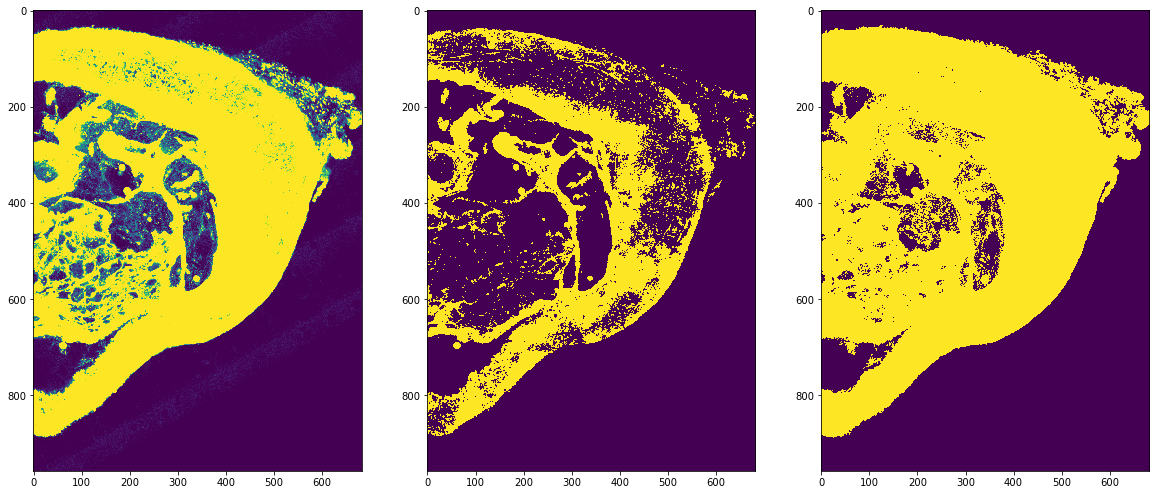

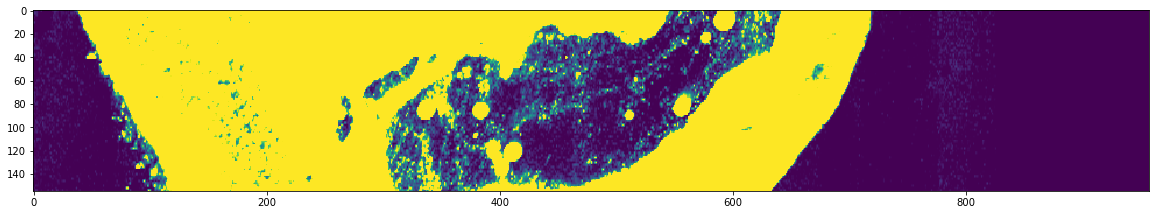

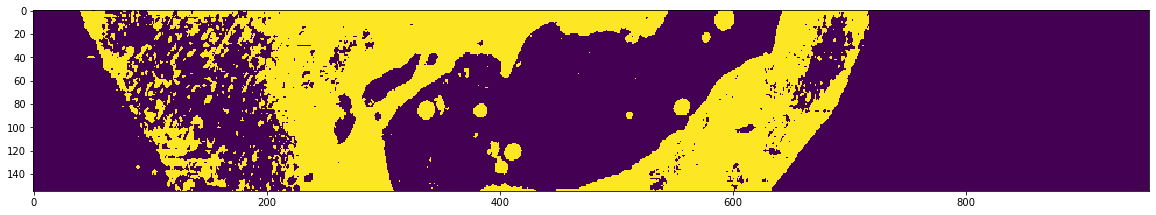

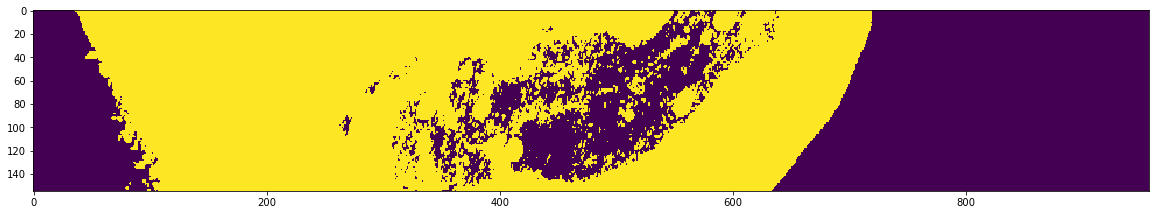

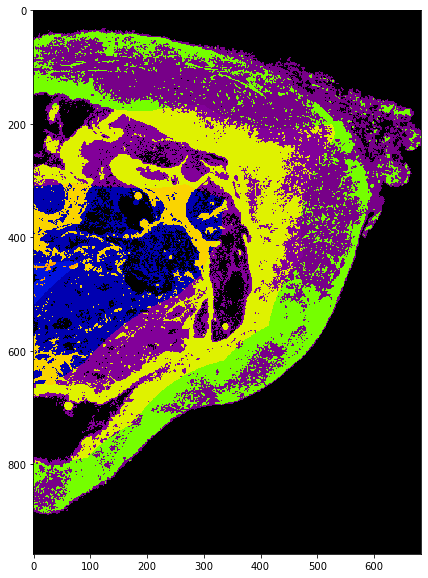

20210324_PDX_STG139_GFP_100x15um
400
50


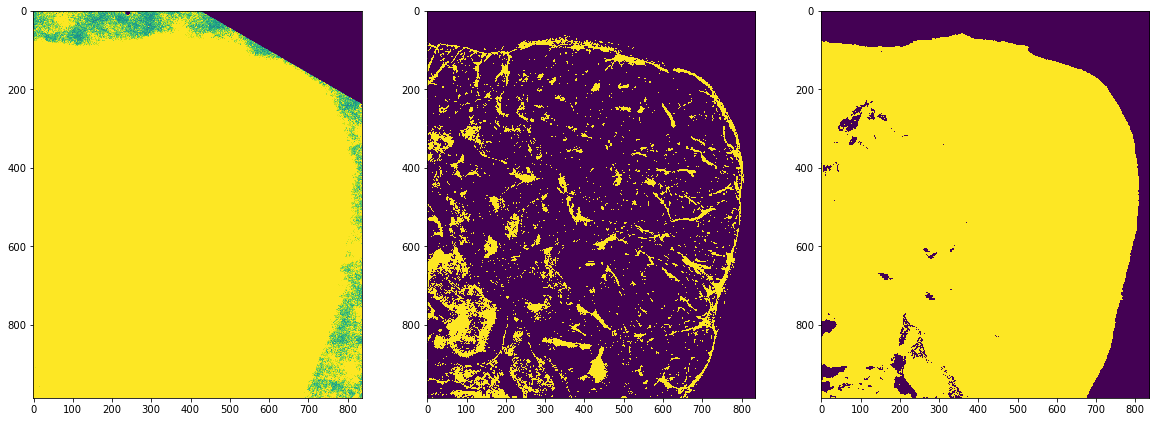

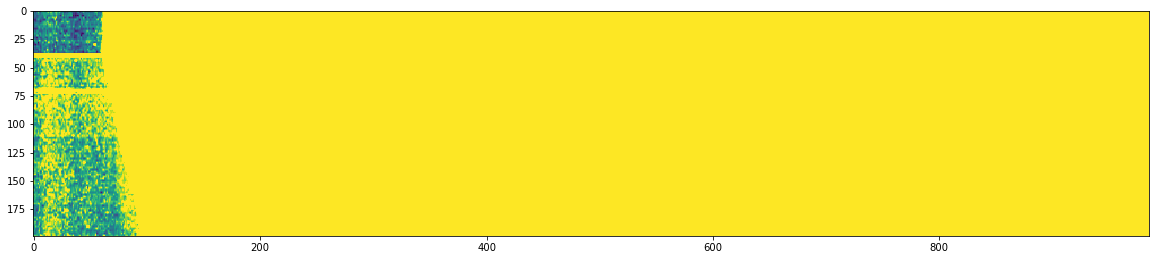

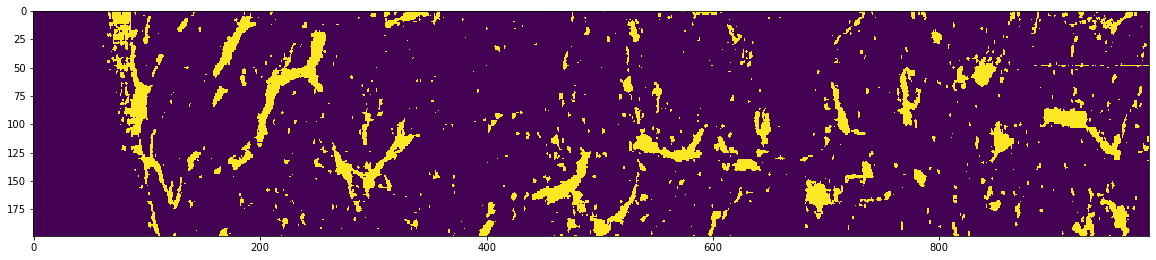

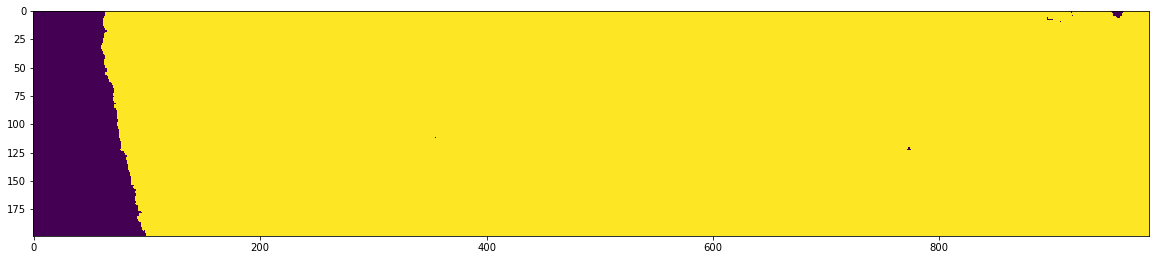

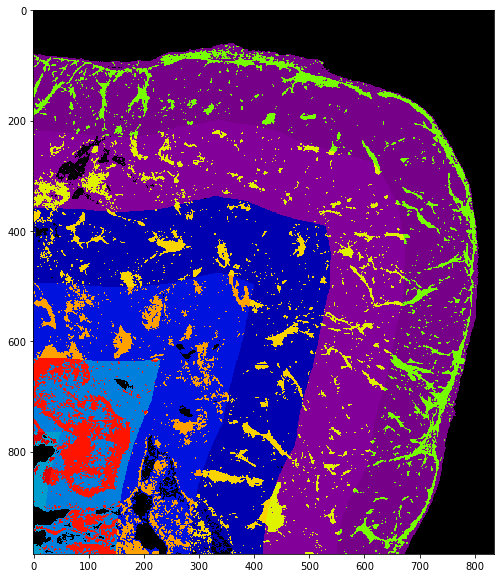

In [22]:

for file_name, full_corner_half, cut_off_x_left, cut_off_x_right, cut_off_y_bottom, cut_off_y_top, angle, threshold_tissue, threshold_stroma, cut_off_bottom, cut_off_top in file_names_all:
    get_segmentation(file_name, angle, threshold_tissue, threshold_stroma, full_corner_half)
    